# Packages 

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from scipy.spatial import distance
import speech_recognition as sr
import threading
import time
import psutil
import seaborn as sns
import matplotlib.pyplot as plt

### Parameters

In [2]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Blink Detection Parameters
EYE_AR_THRESH = 0.25
EYE_AR_CONSEC_FRAMES = 3
blink_counter = 0
blink_total = 0
cheat_intensity = 0
voice_detected = False  # To track voice detection

# Iris and Eye Landmarks
LEFT_EYE = [362, 385, 387, 263, 373, 380]
RIGHT_EYE = [33, 160, 158, 133, 153, 144]
LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]

# Lip Landmarks
UPPER_LIP_INDEX = 13
LOWER_LIP_INDEX = 14
lip_open_count = 0
lip_open = False

# Lists to collect performance data
cpu_usage_data = []
memory_usage_data = []
fps_data = []

# Lists to collect behavior data
blink_data = []
voice_data = []
lip_open_data = []
gaze_data = []

### Functional Modules

In [3]:
# EAR Calculation Function
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

# Extract Eye Landmarks from Face Mesh
def extract_eye_landmarks(landmarks, indices):
    return np.array([(landmarks[i].x, landmarks[i].y) for i in indices])

# Voice Detection Function
def detect_voice():
    global voice_detected
    recognizer = sr.Recognizer()
    mic = sr.Microphone()

    with mic as source:
        recognizer.adjust_for_ambient_noise(source)
        while True:
            try:
                audio = recognizer.listen(source, timeout=2, phrase_time_limit=2)
                recognizer.recognize_google(audio)
                voice_detected = True
            except sr.WaitTimeoutError:
                voice_detected = False
            except sr.UnknownValueError:
                voice_detected = False

# Gaze Direction Utility Functions
def get_landmark_coordinates(landmarks, index, image_shape):
    x = int(landmarks[index].x * image_shape[1])
    y = int(landmarks[index].y * image_shape[0])
    return (x, y)

def get_gaze_direction(landmarks, image_shape):
    left_eye = get_landmark_coordinates(landmarks, 33, image_shape)
    right_eye = get_landmark_coordinates(landmarks, 263, image_shape)
    nose_tip = get_landmark_coordinates(landmarks, 1, image_shape)
    
    eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
    nose_to_eye_vector = np.array([eye_center[0] - nose_tip[0], eye_center[1] - nose_tip[1]])
    
    if nose_to_eye_vector[0] > 20:
        return "head turned Left"
    elif nose_to_eye_vector[0] < -20:
        return "head turned Right"
    else:
        return "Looking Forward"

### Start voice detection 

In [4]:
voice_thread = threading.Thread(target=detect_voice, daemon=True)
voice_thread.start()


<h2 style="font-size:30px;color:Black;font-family:'Times New Roman';">Real Time caputure and Module Capture</br>*Optimization Test Performed on parameters</h2>
<h2 style="font-size:20px;color:green;">min_detection_confidence = 0.1</br>min_tracking_confidence = 0.1</br>setting refine landmarks in the face mesh to false</h2>

<img>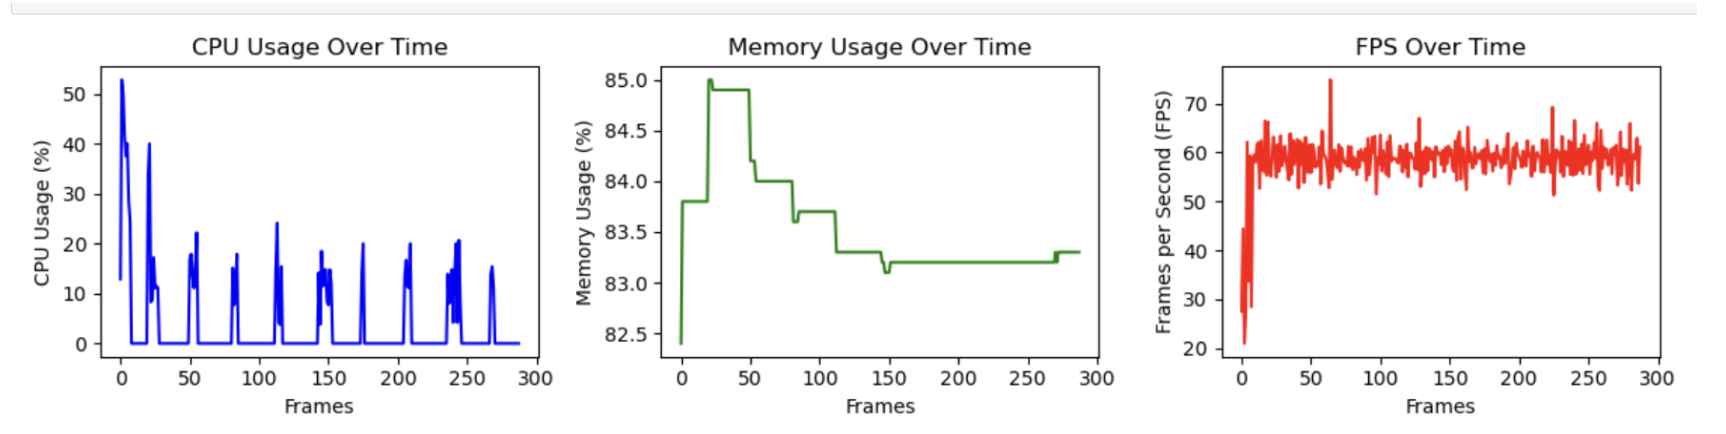</img>

<h2 style="font-size:20px;color:green;">min_detection_confidence = 0.5</br>min_tracking_confidence = 0.5</br>setting refine landmarks in the face mesh to false</h2>

<img>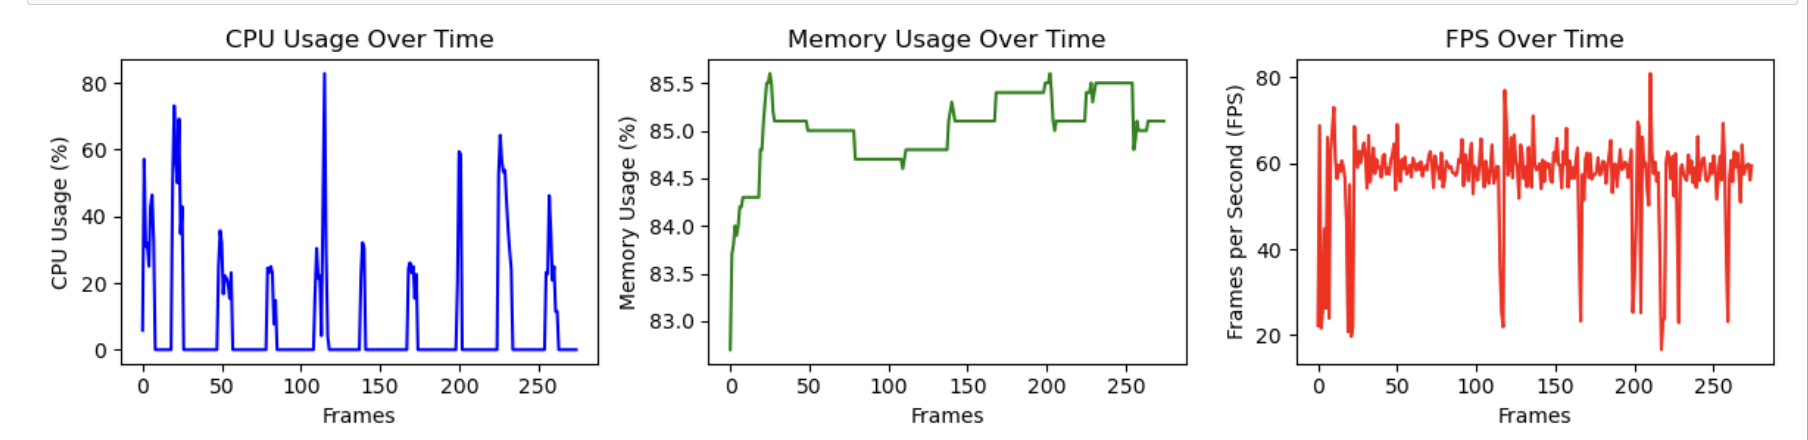</img>

<h2 style="font-size:20px;color:green;">min_detection_confidence = 0.9</br>min_tracking_confidence = 0.9</br>setting refine landmarks in the face mesh to false</h2>

<img>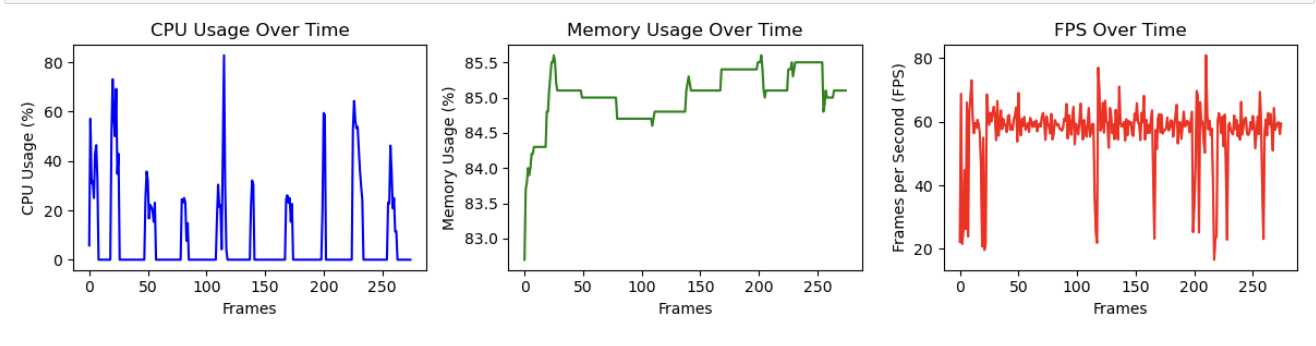</img>

<h2 style="font-size:30px;color:Black;font-family:'Times New Roman';">*Turn Off Unnecessary Drawings</h2>
<h2 style="font-size:20px;color:green;font-family:'Times New Roman';">connections=mp_face_mesh.FACEMESH_TESSELATION</h2>

<img>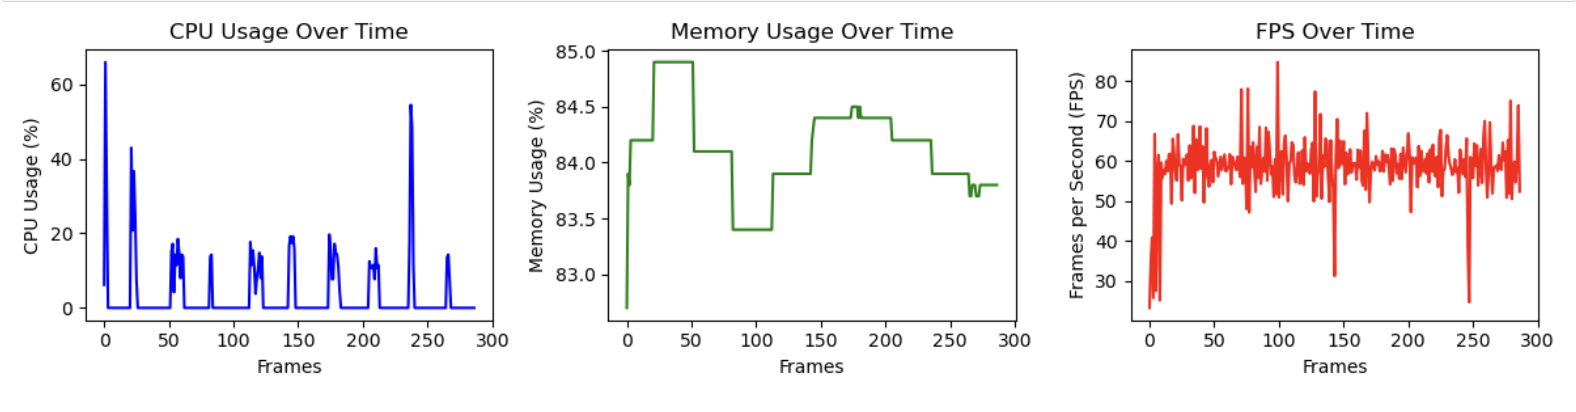</img>

<h2 style="font-size:30px;color:Black;font-family:'Times New Roman';">*Adding a frame skipper</h2>
<h2 style="font-size:20px;color:green;font-family:'Times New Roman';">Skipping frames by 3 fps causes a slight change in the behavior detection but gretly improves the memort usage and cpu load</h2>

<img>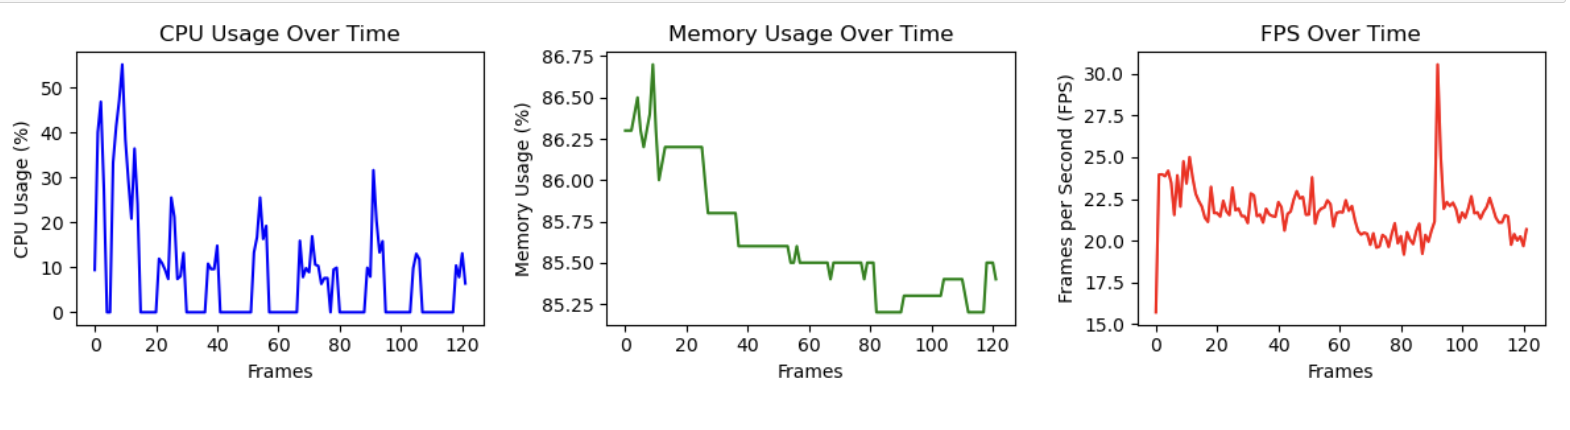</img>

In [5]:
cap = cv2.VideoCapture(0) # Start webcam feed
start_time = time.time()  # Start time for 5-second capture

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1) as face_mesh:
    
    
    frame_counter = 0
    skip_frames = 2  
    
    while cap.isOpened() and (time.time() - start_time) < 10:  # Capture for 5 seconds
        frame_start_time = time.time()  # Start time for frame processing

        success, image = cap.read()
        if frame_counter % skip_frames != 0:
            frame_counter += 1
            continue  # Skip frames
    
        frame_counter += 1
        if not success:
            print("Ignoring empty camera frame.")
            continue

        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        img_h, img_w = image.shape[:2]

        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    image=image,
                    landmark_list=face_landmarks,
#                     connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

                # Extract eye landmarks
                left_eye = extract_eye_landmarks(face_landmarks.landmark, LEFT_EYE)
                right_eye = extract_eye_landmarks(face_landmarks.landmark, RIGHT_EYE)

                # Calculate EAR for both eyes
                left_eye_ear = eye_aspect_ratio(left_eye)
                right_eye_ear = eye_aspect_ratio(right_eye)
                ear = (left_eye_ear + right_eye_ear) / 2.0

                # Detect blink based on EAR threshold
                if ear < EYE_AR_THRESH:
                    blink_counter += 1
                else:
                    if blink_counter >= EYE_AR_CONSEC_FRAMES:
                        blink_total += 1
                        cheat_intensity += 1
                    blink_counter = 0

                # Display blink count
                cv2.putText(image, f"Blinks: {blink_total}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                # Detect gaze direction
                gaze_direction = get_gaze_direction(face_landmarks.landmark, image.shape)
                cv2.putText(image, f"Gaze: {gaze_direction}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

                # Detect lip movement
                upper_lip = face_landmarks.landmark[UPPER_LIP_INDEX]
                lower_lip = face_landmarks.landmark[LOWER_LIP_INDEX]
                lip_distance = abs(upper_lip.y - lower_lip.y)

                if lip_distance > 0.05:
                    if not lip_open:
                        lip_open_count += 1
                        lip_open = True
                else:
                    lip_open = False

                cv2.putText(image, f"Lip Opens: {lip_open_count}", (10, 150), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

                # Detect voice activity
                if voice_detected:
                    cv2.putText(image, "Voice Detected!", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                if lip_open_count >= 3 and voice_detected:
                    cv2.putText(image, "Suspicious Activity Detected!", (10, 300), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
                #########################
                
                # Calculate and display iris positions
                mesh_points = np.array([np.multiply([p.x, p.y], [img_w, img_h]).astype(int) for p in face_landmarks.landmark])

                (l_cx, l_cy), l_radius = cv2.minEnclosingCircle(mesh_points[LEFT_IRIS])
                center_left = np.array([l_cx, l_cy], dtype=np.int32)
                cv2.circle(image, center_left, int(l_radius), (0, 255, 0), 2, cv2.LINE_AA)

                (r_cx, r_cy), r_radius = cv2.minEnclosingCircle(mesh_points[RIGHT_IRIS])
                center_right = np.array([r_cx, r_cy], dtype=np.int32)
                cv2.circle(image, center_right, int(r_radius), (0, 255, 0), 2, cv2.LINE_AA)

                left_eye_width = np.linalg.norm(left_eye[0] - left_eye[3])
                right_eye_width = np.linalg.norm(right_eye[0] - right_eye[3])

                left_gaze_ratio = (center_left[0] - left_eye[0][0]) / left_eye_width
                right_gaze_ratio = (center_right[0] - right_eye[0][0]) / right_eye_width

                iris_gaze_direction = "Center"
                if left_gaze_ratio < 0.5 and right_gaze_ratio < 0.5:
                    iris_gaze_direction = "Looking Left"
                elif left_gaze_ratio > 0.5 and right_gaze_ratio > 0.5:
                    iris_gaze_direction = "Looking Right"

                cv2.putText(image, f'Iris Gaze: {iris_gaze_direction}', (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                ############
                 # Append the captured metrics to the lists
                blink_data.append(blink_total)
                voice_data.append(1 if voice_detected else 0)  # 1 if voice is detected, 0 otherwise
                lip_open_data.append(lip_open_count)
                
                # Convert gaze direction into numerical data for plotting
                gaze_direction_map = {"head turned Left": -1, "Looking Forward": 0, "head turned Right": 1}
                gaze_data.append(gaze_direction_map.get(gaze_direction, 0))


        # Measure CPU and memory usage
        cpu_usage = psutil.cpu_percent()
        memory_usage = psutil.virtual_memory().percent
        frame_end_time = time.time()
        fps = 1 / (frame_end_time - frame_start_time)

        # Store performance metrics
        cpu_usage_data.append(cpu_usage)
        memory_usage_data.append(memory_usage)
        fps_data.append(fps)

        # Display performance metrics
        cv2.putText(image, f"CPU: {cpu_usage:.2f}%", (10, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
        cv2.putText(image, f"Memory: {memory_usage:.2f}%", (10, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)
        cv2.putText(image, f"FPS: {fps:.2f}", (10, 270), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

        # Display the image
        cv2.imshow('Gaze, Blink, Voice, Lip, and Iris Detector', image)

        if cv2.waitKey(5) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1729893892.446213 59808284 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729893892.460657 59817347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729893892.467438 59817347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/prathamhandique/Downloads/anaconda3/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<h2 style="font-size:30px;color:Black;font-family:'Times New Roman';">*Performance Reports Generation</h2>

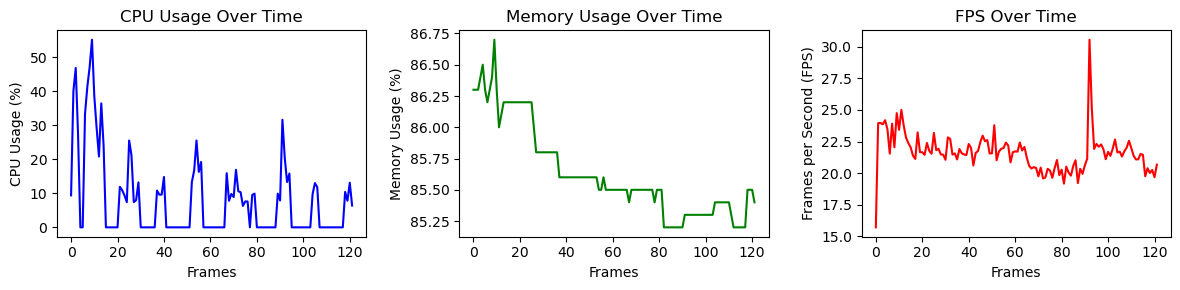

In [6]:
# Plot the performance data with Seaborn
plt.figure(figsize=(12, 3))

# CPU Usage Plot
plt.subplot(1, 3, 1)
sns.lineplot(x=range(len(cpu_usage_data)), y=cpu_usage_data, color='blue')
plt.title("CPU Usage Over Time")
plt.xlabel("Frames")
plt.ylabel("CPU Usage (%)")

# Memory Usage Plot
plt.subplot(1, 3, 2)
sns.lineplot(x=range(len(memory_usage_data)), y=memory_usage_data, color='green')
plt.title("Memory Usage Over Time")
plt.xlabel("Frames")
plt.ylabel("Memory Usage (%)")

# FPS Plot
plt.subplot(1, 3, 3)
sns.lineplot(x=range(len(fps_data)), y=fps_data, color='red')
plt.title("FPS Over Time")
plt.xlabel("Frames")
plt.ylabel("Frames per Second (FPS)")

plt.tight_layout()
plt.show()


<h2 style="font-size:30px;color:Black;font-family:'Times New Roman';">*Behavioral Reports Generation</h2>

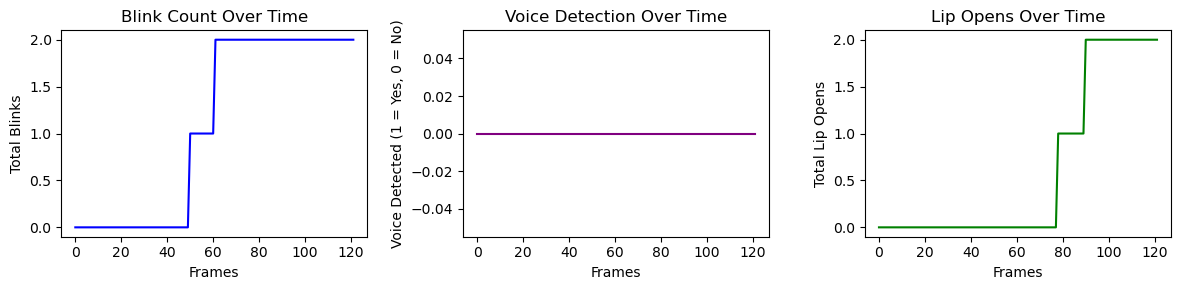

In [7]:
plt.figure(figsize=(12, 3))
# Blink Count Plot
plt.subplot(1, 3, 1)
sns.lineplot(x=range(len(blink_data)), y=blink_data, color='blue')
plt.title("Blink Count Over Time")
plt.xlabel("Frames")
plt.ylabel("Total Blinks")

# Voice Detection Plot
plt.subplot(1, 3, 2)
sns.lineplot(x=range(len(voice_data)), y=voice_data, color='purple')
plt.title("Voice Detection Over Time")
plt.xlabel("Frames")
plt.ylabel("Voice Detected (1 = Yes, 0 = No)")

# Lip Opens Plot
plt.subplot(1, 3, 3)
sns.lineplot(x=range(len(lip_open_data)), y=lip_open_data, color='green')
plt.title("Lip Opens Over Time")
plt.xlabel("Frames")
plt.ylabel("Total Lip Opens")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()